In [ ]:
import scipy.stats as stats
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_hac
warnings.filterwarnings("ignore", category=DeprecationWarning)
from google.colab import files

In [ ]:
upload = files.upload()

Saving Merged_Factor_Data.xlsx to Merged_Factor_Data.xlsx


In [ ]:
upload = files.upload()

Saving returns.csv to returns.csv


In [ ]:
factor_df = pd.read_excel('Merged_Factor_Data.xlsx')
factor_df["Date"] = pd.to_datetime(factor_df["Date"], format="%Y%m")
factor_df.head()

,Date,Mkt-RF_EM,SMB_EM,HML_EM,RMW_EM,CMA_EM,WML,Mkt-RF_US,SMB_US,HML_US,RMW_US,CMA_US,Mom,RF
0,1992-07-01,-0.49,1.74,-2.00,3.93,-2.72,5.43,3.77,-0.62,-0.56,1.30,-0.91,1.56,0.31
1,1992-08-01,-3.64,-0.25,-2.30,3.57,-2.25,5.67,-2.38,-0.42,-1.10,3.72,-1.65,-0.51,0.26
2,1992-09-01,-1.22,-3.29,-0.11,1.34,0.98,-1.84,1.19,0.48,-0.26,1.64,-0.59,1.49,0.26
3,1992-10-01,4.40,0.00,-0.75,-2.67,-5.13,-1.32,1.02,2.07,-1.98,1.24,-0.79,2.48,0.23
4,1992-11-01,-0.72,2.79,-0.61,0.16,-8.79,-3.45,4.13,3.94,-1.35,-0.68,-1.59,-0.15,0.23


In [ ]:
returns_df = pd.read_csv('returns.csv')
returns_df["Date"] = pd.to_datetime(returns_df["Date"])
returns_df.head()

,Date,MSCI EM,MSCI US,TB3MS,US Corporate High Yield,Intermediate Yield,Equity REIT,Mortgage REIT,GOLD,US long treasury,...,absolute_Bond_IY_ROR_Credit,Dual_Credit,relative_REIT,absolute_REIT_equity_ROR_REIT,absolute_REIT_mortgage_ROR_REIT,Dual_REIT,relative_Stress,absolute_Stress_gold_ROR_Stress,absolute_Stress_LT_ROR_Stress,Dual_Stress
0,1987-12-01,10000.0,32122.540954,5.77,174.91,397.53,802.51,38.8313,484.10,339.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1988-01-01,10983.8,33467.346459,5.81,180.76,409.20,846.49,42.0511,458.00,359.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1988-02-01,11021.1,34837.036256,5.66,186.61,414.68,878.86,42.0154,426.15,363.68,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1988-03-01,12204.6,33639.591152,5.70,184.67,413.79,883.23,41.3837,456.95,352.66,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1988-04-01,12856.1,33915.912167,5.91,186.08,413.19,889.37,41.2377,449.00,346.47,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#Factor Analysis on Dual Equity

In [ ]:
# Extract Dual_Equity returns and merge with factor data
if "Dual_Equity" in returns_df.columns:
    merged_df = returns_df[["Date", "Dual_Equity"]].merge(factor_df, on="Date", how="inner")
else:
    raise ValueError("Dual_Equity column not found in returns.csv")
# Drop rows with missing values
merged_df.dropna(inplace=True)

In [ ]:
# Convert factor data from percentage format to decimal (divide by 100)
factor_columns = ["Mkt-RF_US", "SMB_US", "HML_US", "RMW_US", "CMA_US",
                   "Mkt-RF_EM", "SMB_EM", "HML_EM", "RMW_EM", "CMA_EM",
                   "Mom", "WML", "RF"]
merged_df[factor_columns] = merged_df[factor_columns] / 100

# Define dependent variable (excess return of Dual_Equity)
merged_df["Excess_Dual_Equity"] = merged_df["Dual_Equity"] - merged_df["RF"]

# Define independent variables (all factors: US and Emerging Markets)
all_factors = ["Mkt-RF_US", "SMB_US", "HML_US", "RMW_US", "CMA_US",
               "Mkt-RF_EM", "SMB_EM", "HML_EM", "RMW_EM", "CMA_EM",
               "Mom", "WML"]

In [ ]:
X_all = merged_df[all_factors]
X_all = sm.add_constant(X_all)  # Add intercept

# Run OLS regression with Newey-West adjusted standard errors
y = merged_df["Excess_Dual_Equity"]
model_all = sm.OLS(y, X_all).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

# Display regression results
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:     Excess_Dual_Equity   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.645
Method:                 Least Squares   F-statistic:                     26.43
Date:                Sun, 30 Mar 2025   Prob (F-statistic):           4.67e-43
Time:                        00:36:39   Log-Likelihood:                 876.98
No. Observations:                 390   AIC:                            -1728.
Df Residuals:                     377   BIC:                            -1676.
Df Model:                          12                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.002      0.383      0.7

1. Alpha (const): 0.0006 (t-stat: 0.383, p-value: 0.702)

 No longer significant, meaning Dual_Equity does not generate excess returns beyond factor exposures.

2. Market Factor Exposure:
- US Market (Mkt-RF_US): 0.4386 (t-stat: 6.099, p-value: <0.001) ✅ Highly significant
- Emerging Market (Mkt-RF_EM): 0.3464 (t-stat: 5.724, p-value: <0.001) ✅ Highly significant

  **Interpretation**: Dual_Equity has strong exposure to both US and Emerging Market risk factors.

3. Size Factor (SMB):

- US SMB: 0.0191 (t-stat: 0.391, p-value: 0.696) ❌ Not significant
- EM SMB: -0.1581 (t-stat: -1.830, p-value: 0.067) ⚠️ Marginally significant (negative size exposure)

4. Value Factor (HML):

- US HML: -0.0297 (t-stat: -0.364, p-value: 0.716) ❌ Not significant
- EM HML: 0.0678 (t-stat: 0.811, p-value: 0.418) ❌ Not significant

5. Profitability and Investment Factors (RMW & CMA):

- US RMW: 0.1423 (t-stat: 1.684, p-value: 0.092) ⚠️ Marginally significant
- EM RMW: -0.2126 (t-stat: -1.826, p-value: 0.068) ⚠️ Marginally significant (negative exposure)
- US CMA: -0.0773 (t-stat: -0.842, p-value: 0.400) ❌ Not significant
- EM CMA: 0.1810 (t-stat: 1.756, p-value: 0.079) ⚠️ Marginally significant

6. Momentum Factors:

- US Momentum (Mom): 0.1972 (t-stat: 4.527, p-value: <0.001) ✅ Highly significant
- Emerging Market Momentum (WML): 0.2284 (t-stat: 3.350, p-value: 0.001) ✅ Highly significant

  **Interpretation**: Dual_Equity has strong momentum exposure, suggesting that its returns are driven by momentum effects in both US and Emerging markets.

# Rolling windows

In [ ]:
# Define rolling window size
window_size = 120

# Store results for rolling regression
rolling_results = []

In [ ]:
# Iterate over rolling windows
for start in range(len(merged_df) - window_size):
    end = start + window_size
    rolling_window = merged_df.iloc[start:end]

    # Define dependent and independent variables
    y_rolling = rolling_window["Excess_Dual_Equity"]
    X_rolling = rolling_window[all_factors]
    X_rolling = sm.add_constant(X_rolling)

    # Run regression with Newey-West standard errors
    model_rolling = sm.OLS(y_rolling, X_rolling).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

    # Store rolling results
    rolling_results.append({
        "Date": merged_df.iloc[end]["Date"],  # Use the last date of the window
        "Alpha": model_rolling.params["const"],
        "Alpha_t": model_rolling.tvalues["const"],
        "R2": model_rolling.rsquared
    })

# Convert to DataFrame
rolling_results_df = pd.DataFrame(rolling_results)
rolling_results_df

,Date,Alpha,Alpha_t,R2
0,2002-07-01,0.001834,0.691649,0.713916
1,2002-08-01,0.000906,0.333460,0.716418
2,2002-09-01,0.001421,0.531944,0.717235
3,2002-10-01,0.002169,0.822346,0.707060
4,2002-11-01,0.002153,0.796564,0.704995
...,...,...,...,...
265,2024-08-01,-0.001215,-0.481643,0.725793
266,2024-09-01,-0.001251,-0.500307,0.724555
267,2024-10-01,-0.001731,-0.757323,0.724664
268,2024-11-01,-0.001685,-0.734693,0.725392


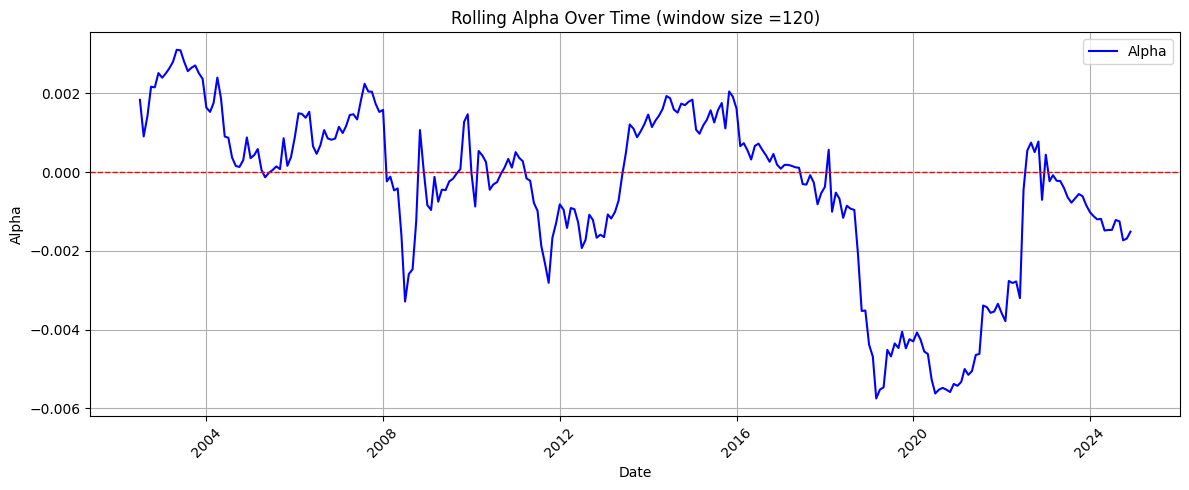

In [ ]:
# Plot Alpha over time
plt.figure(figsize=(12, 5))
plt.plot(rolling_results_df["Date"], rolling_results_df["Alpha"], label="Alpha", color='blue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title(f"Rolling Alpha Over Time (window size ={window_size})")
plt.xlabel("Date")
plt.ylabel("Alpha")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

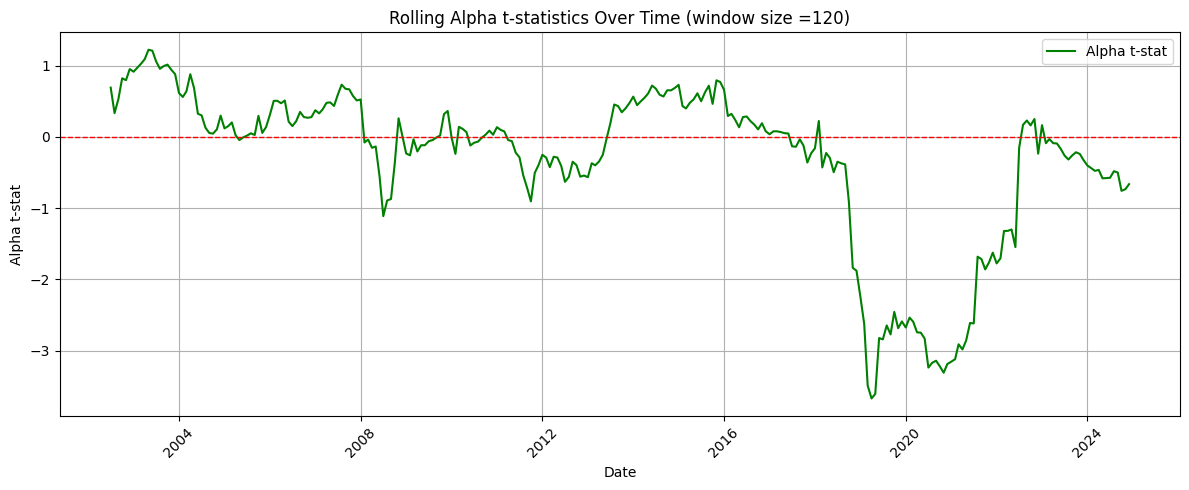

In [ ]:
# Plot Alpha t-statistics over time
plt.figure(figsize=(12, 5))
plt.plot(rolling_results_df["Date"], rolling_results_df["Alpha_t"], label="Alpha t-stat", color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title(f"Rolling Alpha t-statistics Over Time (window size ={window_size})")
plt.xlabel("Date")
plt.ylabel("Alpha t-stat")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

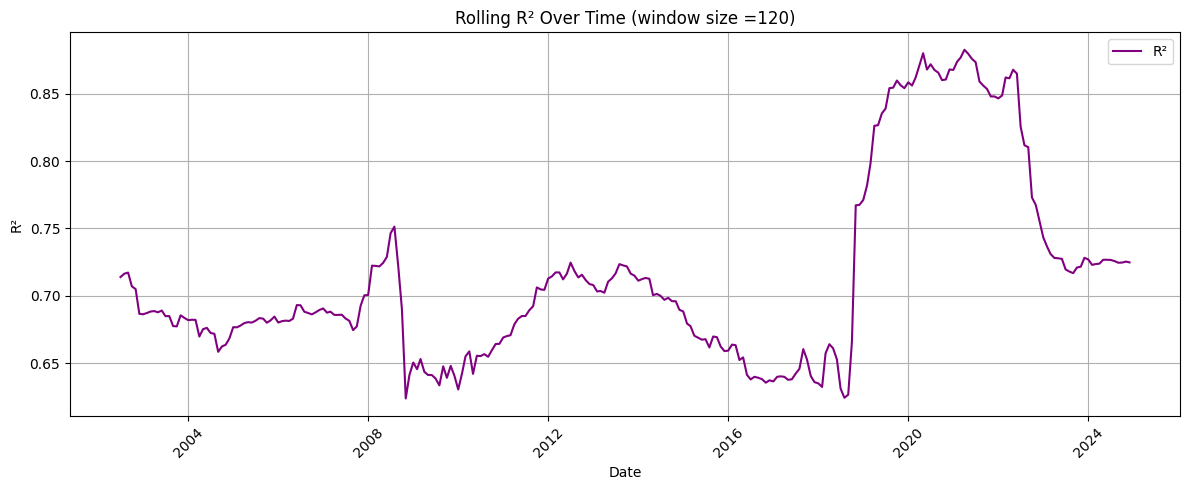

In [ ]:
# Plot R² over time
plt.figure(figsize=(12, 5))
plt.plot(rolling_results_df["Date"], rolling_results_df["R2"], label="R²", color='purple')
plt.title(f"Rolling R² Over Time (window size ={window_size})")
plt.xlabel("Date")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

1. Rolling Alpha Over Time
- Alpha fluctuates around zero throughout the sample.
- Some periods (e.g. 2003–2007, 2013–2017) show modest positive alpha, but:
- Long stretches post-2018 show negative alpha, particularly sharp around 2019–2020.
- No persistent alpha — Dual_Equity does not consistently generate positive excess returns over time. Its performance varies significantly across regimes.

2. Rolling Alpha t-statistics
- The t-stat is rarely above +2, which is the typical threshold for statistical significance.
- In many periods, especially around 2020, it's significantly negative (e.g., below -3).
- After 2020, it stays mostly below zero.
- Even when alpha is positive, it’s not statistically significant. The negative t-stats in recent years suggest a potential deterioration in strategy performance or structural change.

3. Rolling R² (Model Fit)
- The R² is relatively high, consistently around 0.65–0.85.
- Especially post-2019, R² spikes to ~0.87, meaning the factor model explains almost 90% of the return variation.
- Slight decline in 2023–2024, but still high.
- The model explains a large portion of the strategy’s return variation, especially during recent years. That indicates performance is highly driven by common risk factors, not by unique alpha.

Overall Conclusion:
- High R²: The strategy's returns are well explained by known risk factors.
- No persistent or significant alpha: The strategy does not consistently outperform after controlling for market, size, value, momentum, profitability, and investment factors.
- Recent performance deterioration: Alpha and t-stats drop sharply around 2019–2020, suggesting regime shift or structural degradation.

# Walk-Forward Validation

In [ ]:
# stress testing a long-term allocation strategy
min_train_size = 180
step = 12

cv_results = []

In [ ]:
for start in range(min_train_size, len(merged_df) - step):
    train = merged_df.iloc[:start]
    test = merged_df.iloc[start:start+step]

    y_train = train["Excess_Dual_Equity"]
    X_train = sm.add_constant(train[all_factors], has_constant='add')

    model = sm.OLS(y_train, X_train).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

    X_test = sm.add_constant(test[all_factors], has_constant='add')
    y_test = test["Excess_Dual_Equity"]
    y_pred = model.predict(X_test)

    cv_results.append({
        "Train_End_Date": train["Date"].iloc[-1],
        "Test_End_Date": test["Date"].iloc[-1],
        "Alpha": model.params["const"],
        "Alpha_t": model.tvalues["const"],
        "R2_Train": model.rsquared,
        "R2_Test": y_test.corr(y_pred) ** 2 if len(y_test) > 1 else None
    })
cv_results_df = pd.DataFrame(cv_results)

In [ ]:
cv_results_df

,Train_End_Date,Test_End_Date,Alpha,Alpha_t,R2_Train,R2_Test
0,2007-06-01,2008-06-01,0.001461,0.696532,0.713477,0.941979
1,2007-07-01,2008-07-01,0.001687,0.803879,0.713175,0.925740
2,2007-08-01,2008-08-01,0.001481,0.718447,0.713189,0.881743
3,2007-09-01,2008-09-01,0.001610,0.779486,0.714652,0.621345
4,2007-10-01,2008-10-01,0.001862,0.897382,0.718805,0.243352
...,...,...,...,...,...,...
193,2023-07-01,2024-07-01,0.000713,0.426758,0.652287,0.916651
194,2023-08-01,2024-08-01,0.000687,0.412277,0.652648,0.910391
195,2023-09-01,2024-09-01,0.000622,0.374252,0.653446,0.888395
196,2023-10-01,2024-10-01,0.000604,0.364986,0.654070,0.865470


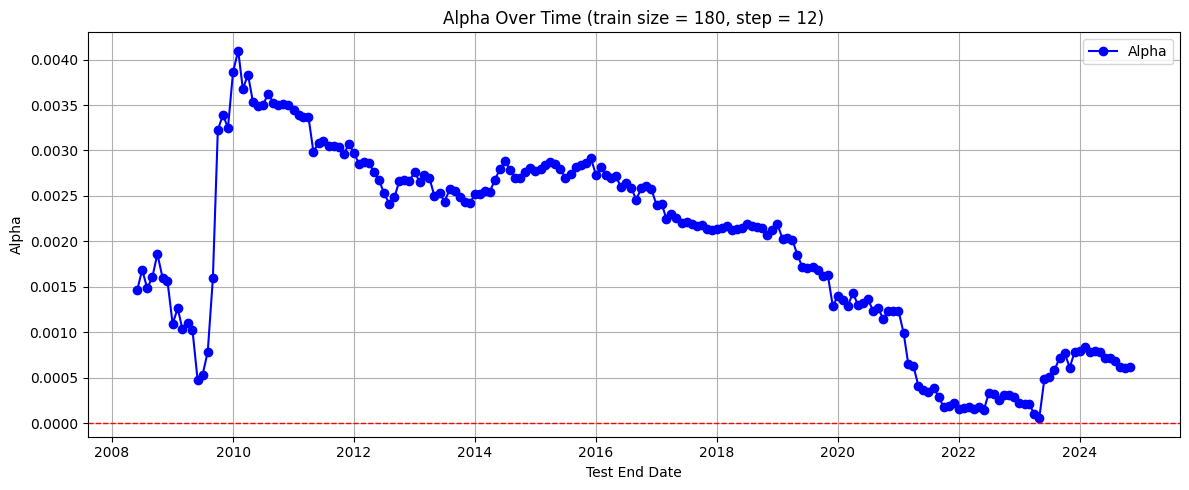

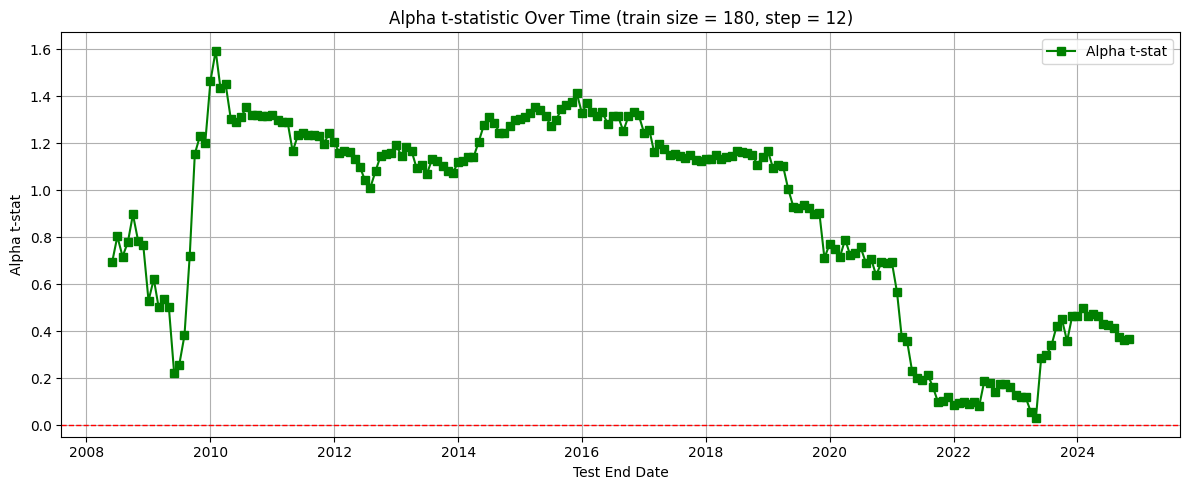

In [ ]:
# --- Plot Alpha ---
plt.figure(figsize=(12, 5))
plt.plot(cv_results_df["Test_End_Date"], cv_results_df["Alpha"], label="Alpha", color="blue", marker="o")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title(f"Alpha Over Time (train size = {min_train_size}, step = {step})")
plt.xlabel("Test End Date")
plt.ylabel("Alpha")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# --- Plot Alpha t-statistics ---
plt.figure(figsize=(12, 5))
plt.plot(cv_results_df["Test_End_Date"], cv_results_df["Alpha_t"], label="Alpha t-stat", color="green", marker="s")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title(f"Alpha t-statistic Over Time (train size = {min_train_size}, step = {step})")
plt.xlabel("Test End Date")
plt.ylabel("Alpha t-stat")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

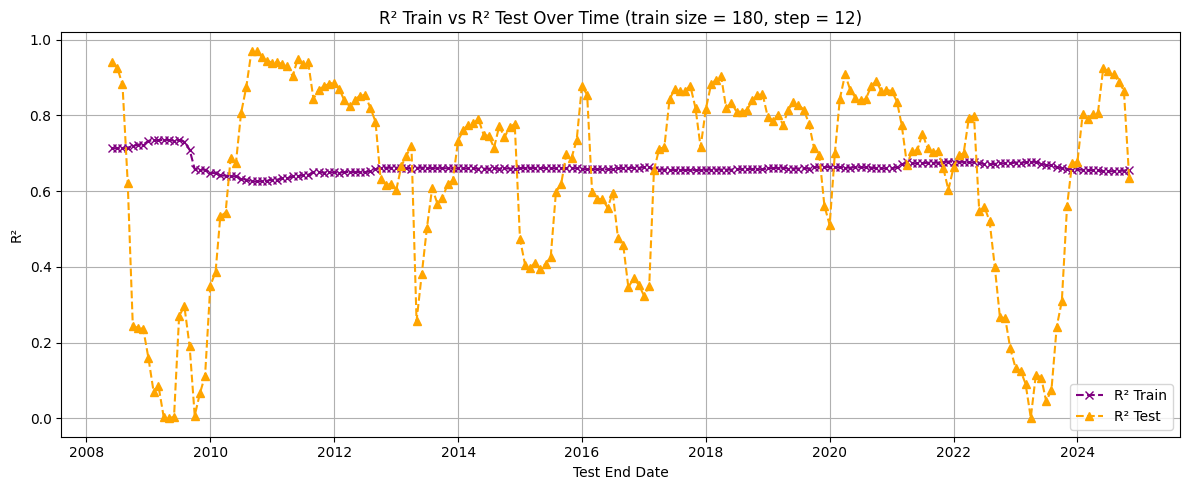

In [ ]:
# --- R² Comparison Plot ---
plt.figure(figsize=(12, 5))
plt.plot(cv_results_df["Test_End_Date"], cv_results_df["R2_Train"], label="R² Train", color="purple", linestyle="--", marker="x")
plt.plot(cv_results_df["Test_End_Date"], cv_results_df["R2_Test"], label="R² Test", color="orange", linestyle="--", marker="^")
plt.title(f"R² Train vs R² Test Over Time (train size = {min_train_size}, step = {step})")
plt.xlabel("Test End Date")
plt.ylabel("R²")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

1. Alpha Over Time (Cross-Validation)
- Alpha values start off strong (2009–2015), peaking around 0.004 (0.4%) monthly, quite impressive.
- Then alpha begins a steady decline, losing momentum through 2016–2019.
- Post-2020, alpha drops closer to zero and stabilizes below 0.001.
- The strategy had some genuine outperformance in the early-to-mid period, but alpha faded significantly in later years — possibly due to:Crowding into similar signals, Regime changes post-2020 (e.g., inflation, rates, EM/US dispersion), Or breakdown in factor efficiency.

2. Alpha t-statistics Over Time
- Starts off above 1.5, peaking around 2010.
- Gradual decline begins in 2014–2016, dropping near statistical insignificance (t < 1).
- Post-2020, alpha t-stats hover below 0.5, never reaching significance.
- Even if alpha is positive, it's not statistically reliable — particularly in the post-COVID era. This suggests alpha may be fading into noise.

3. R² Train vs. R² Test
- R² Train is flat and stable around 0.65–0.70. That’s good — the model fits the training data consistently.
- R² Test is highly volatile, swinging between 0 and nearly 1.0 in places.
- In some periods, test R² drops below 0.2 or even 0.0 — this indicates the model failed out-of-sample at times.
- This is a textbook case of a model that: Fits well in-sample, but Generalizes inconsistently, depending on the regime. Suggests the strategy’s factor structure may be unstable, or overfit to the past.



In [ ]:
min_train_size = 180
step = 12
cv_results = []

for start in range(min_train_size, len(merged_df) - step):
    # Split into train and test
    train = merged_df.iloc[:start]
    test = merged_df.iloc[start:start + step]

    # Prepare training data
    X_train = sm.add_constant(train[all_factors], has_constant='add')
    y_train = train["Excess_Dual_Equity"]
    model_train = sm.OLS(y_train, X_train).fit(cov_type="HAC", cov_kwds={"maxlags": 3})

    # Predict on test set
    X_test = sm.add_constant(test[all_factors], has_constant='add')
    y_test = test["Excess_Dual_Equity"]
    y_pred = model_train.predict(X_test)

    # Compute realized alpha using fixed training betas
    beta_vector = model_train.params.drop("const").values
    X_factors_test = test[all_factors].values
    predicted_component = X_factors_test @ beta_vector
    residuals = y_test.values - predicted_component
    realized_alpha = residuals.mean()
    std_err = residuals.std(ddof=1) / np.sqrt(len(residuals))
    realized_alpha_t = realized_alpha / std_err if std_err != 0 else np.nan

    # Store results
    cv_results.append({
        "Train_End_Date": train["Date"].iloc[-1],
        "Test_End_Date": test["Date"].iloc[-1],
        "Test_Alpha": model_train.params["const"],
        "Test_Alpha_t": model_train.tvalues["const"],
        "Realized_Alpha": realized_alpha,
        "Realized_Alpha_t": realized_alpha_t,
        "R2_Train": model_train.rsquared,
        "R2_Test": y_test.corr(y_pred) ** 2 if len(y_test) > 1 else None
    })

# Convert to DataFrame
cv_results_df = pd.DataFrame(cv_results)


In [ ]:
cv_results_df

,Train_End_Date,Test_End_Date,Test_Alpha,Test_Alpha_t,Realized_Alpha,Realized_Alpha_t,R2_Train,R2_Test
0,2007-06-01,2008-06-01,0.001461,0.696532,-0.003252,-0.310038,0.713477,0.941979
1,2008-06-01,2009-06-01,0.000471,0.223164,0.030283,1.520278,0.732994,0.004216
2,2009-06-01,2010-06-01,0.003487,1.290586,-0.006292,-0.855581,0.639102,0.674452
3,2010-06-01,2011-06-01,0.003083,1.235118,-0.001807,-0.313849,0.638763,0.949064
4,2011-06-01,2012-06-01,0.002670,1.098867,0.000840,0.135742,0.650541,0.852155
5,2012-06-01,2013-06-01,0.002529,1.110095,0.005942,1.248716,0.661743,0.380660
6,2013-06-01,2014-06-01,0.002797,1.276641,0.004843,1.204753,0.658979,0.748116
7,2014-06-01,2015-06-01,0.002795,1.317860,0.001205,0.203133,0.660684,0.408275
8,2015-06-01,2016-06-01,0.002595,1.282717,-0.005225,-0.742640,0.657508,0.555957
9,2016-06-01,2017-06-01,0.002204,1.150832,0.000284,0.074570,0.655445,0.842466


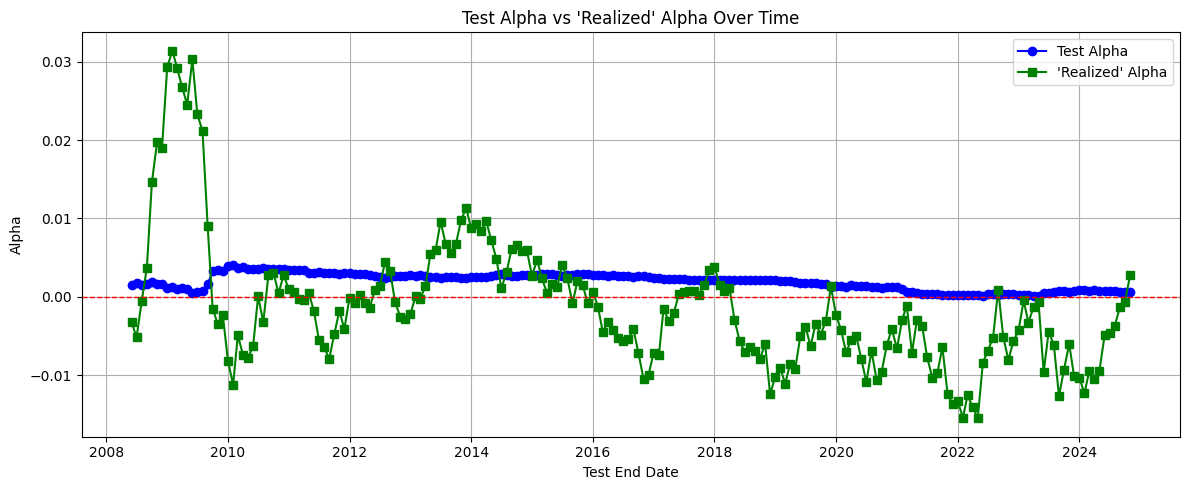

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(cv_results_df["Test_End_Date"], cv_results_df["Test_Alpha"], label="Test Alpha", color="blue", marker="o")
plt.plot(cv_results_df["Test_End_Date"], cv_results_df["Realized_Alpha"], label="'Realized' Alpha", color="green", marker="s")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Test Alpha vs 'Realized' Alpha Over Time")
plt.xlabel("Test End Date")
plt.ylabel("Alpha")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

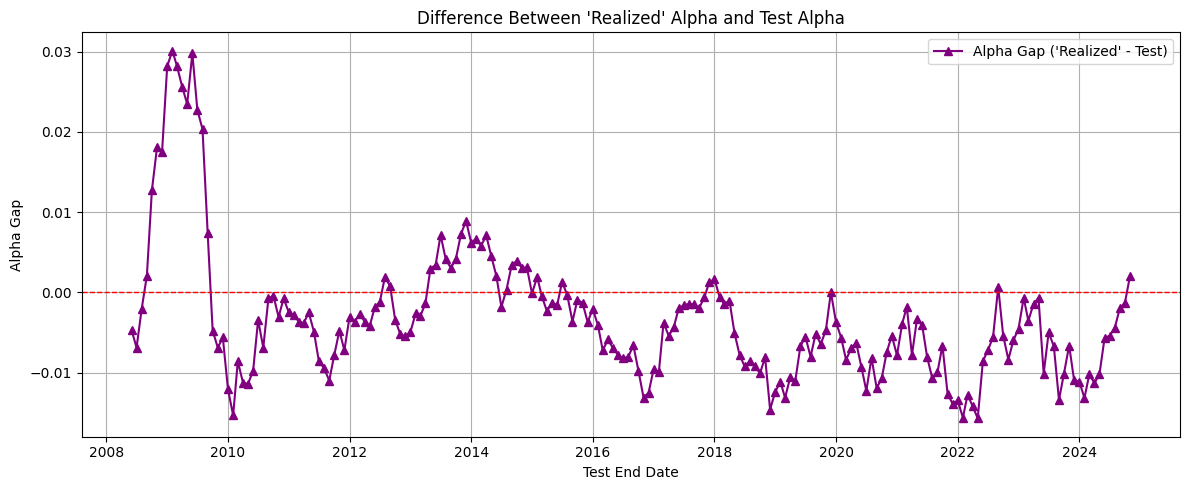

In [ ]:
cv_results_df["Alpha_Diff"] = cv_results_df["Realized_Alpha"] - cv_results_df["Test_Alpha"]

plt.figure(figsize=(12, 5))
plt.plot(cv_results_df["Test_End_Date"], cv_results_df["Alpha_Diff"], label="Alpha Gap ('Realized' - Test)", color="purple", marker="^")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Difference Between 'Realized' Alpha and Test Alpha")
plt.xlabel("Test End Date")
plt.ylabel("Alpha Gap")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()